# PROJET DEEP LEARNING: RESEAU DE CONVOLUTION APPLIQUE A LA CLASSIFICATION AUTOMATIQUE D'IMAGE  
# Enseignant: M.Stephane GENTRIC
# Auteur: Zoumana KEITA, Etudiant 5A - ESIEA - Majeure DTE

## Introduction  
Le but de ce projet est de faire de la classification automatique d'images. Le critère de classification n'a pas été déterminé, cependant, nous allons durant la phase d'analyses, déterminer le critère selon lequel nous allons classifier nos images.  

# PARTIE I: CHARGEMENT ET PRE-PROCESSING DE NOS DONNEES  

## 1.0 Importation des librairies utiles pour le projet.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from time import time

%matplotlib inline
sns.set()

## A- Chargement et analyse de nos données. 

In [2]:
#Nombre d'exemples dans nos bases d'entrainement et de test.
num_train_images  = 111430
num_test_images  = 10130 

# taille des images 56*56*3 (RGB)
image_dim = 9408 # (= 56 x 56 x 3)

train_images_fname  = './DataBases/db_train.raw'
test_images_fname  = './DataBases/db_test.raw'
train_labels_fname  = './DataBases/label_train.txt'

In [3]:
#Chargement des labels de la base d'apprentissage.
train_images_label = np.loadtxt(train_labels_fname, dtype=np.float64)

## B- Transformation de nos données en formes matricielles  

In [4]:
# Pour la base de Train
fTrain = open(train_images_fname, 'rb')
train_images_data  = np.empty([num_train_images, image_dim], dtype=np.float32)
for i in range(num_train_images):
    train_images_data[i,:] = np.fromfile(fTrain, dtype=np.uint8, count=image_dim).astype(np.float32)
fTrain.close()

# Pour la base de Test
fTest = open(test_images_fname, 'rb')
test_images_data  = np.empty([num_test_images, image_dim], dtype=np.float32)
for i in range(num_test_images):
    test_images_data[i,:] = np.fromfile(fTest, dtype=np.uint8, count=image_dim).astype(np.float32)
fTest.close()

#### Vérification de la taille de nos données

In [5]:
print("Informations Bases de Train et Test: ")
print("- Train  :", train_images_data.shape)
print("- Test   :", test_images_data.shape)
print("- Labels :", train_images_label.shape)

Informations Bases de Train et Test: 
- Train  : (111430, 9408)
- Test   : (10130, 9408)
- Labels : (111430,)


### C- Compréhension de notre problème de classement.  
Comme énoncé précédemment, le motif de classification de nos données n'a pas été déterminé. Afin de remédier à cette problématique, nous allons visualiser quelques images associées à chaque label (0/1) afin de trouver la bonne méthode de classification.  

In [6]:
#Cette méthode nous permet de visualiser quelques images de notre base d'entrainement.
def printImagesFromLabel(label, nrows=9, ncols=9):
    print("========================================================================================")
    print("- Pour Label : ", label)
    print("========================================================================================")
    index = np.where(train_images_label == label)[0]
    fig = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
    for i in range(1, ncols*nrows+1):
        plt.subplot(nrows, ncols, i)
        plt.imshow(train_images_data[index[i]].reshape(56, 56, 3).astype(np.uint8))
        plt.xticks([]), plt.yticks([])
        plt.title("class {:.0f}".format(train_images_label[index[i]]))
    plt.show()
    print("========================================================================================")

- Pour Label :  0


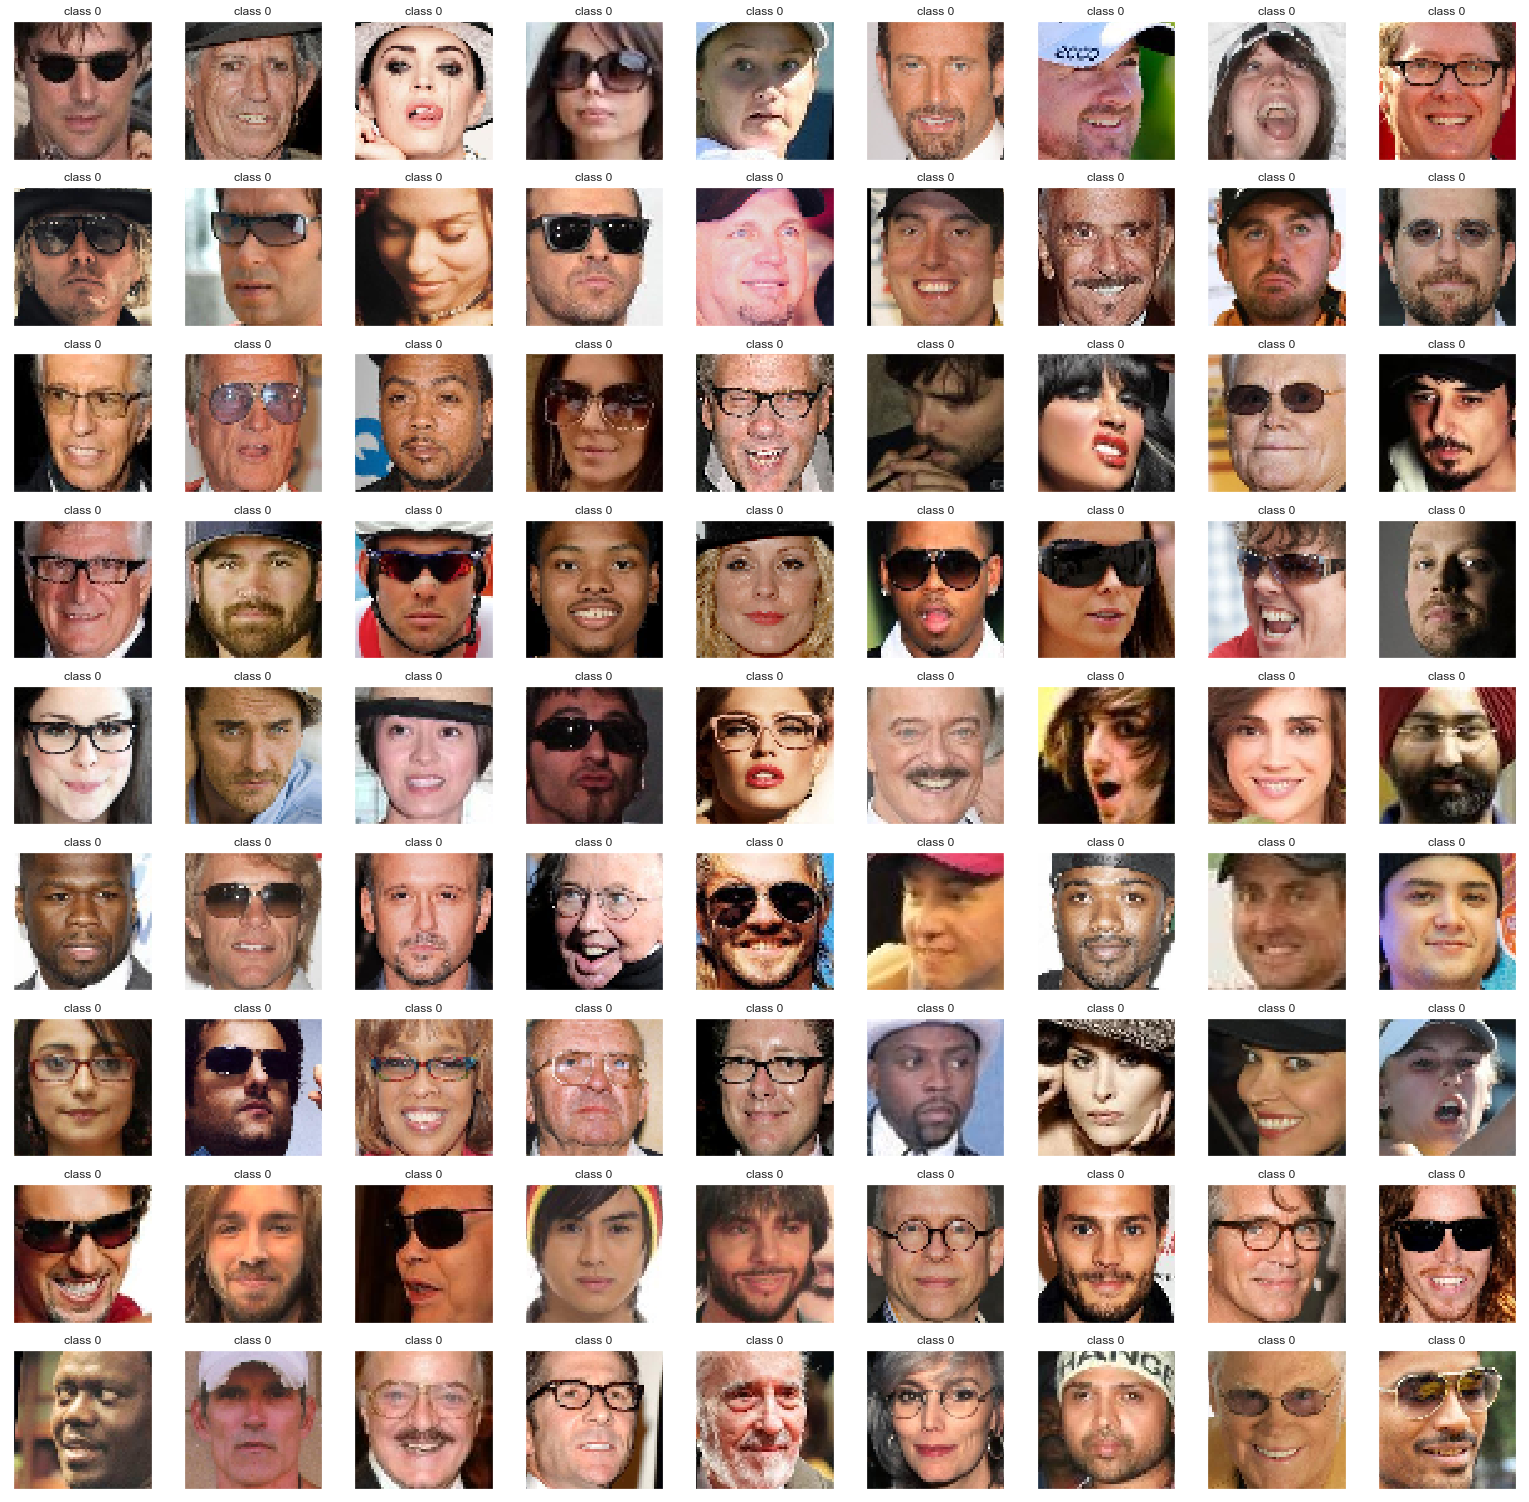

- Pour Label :  1


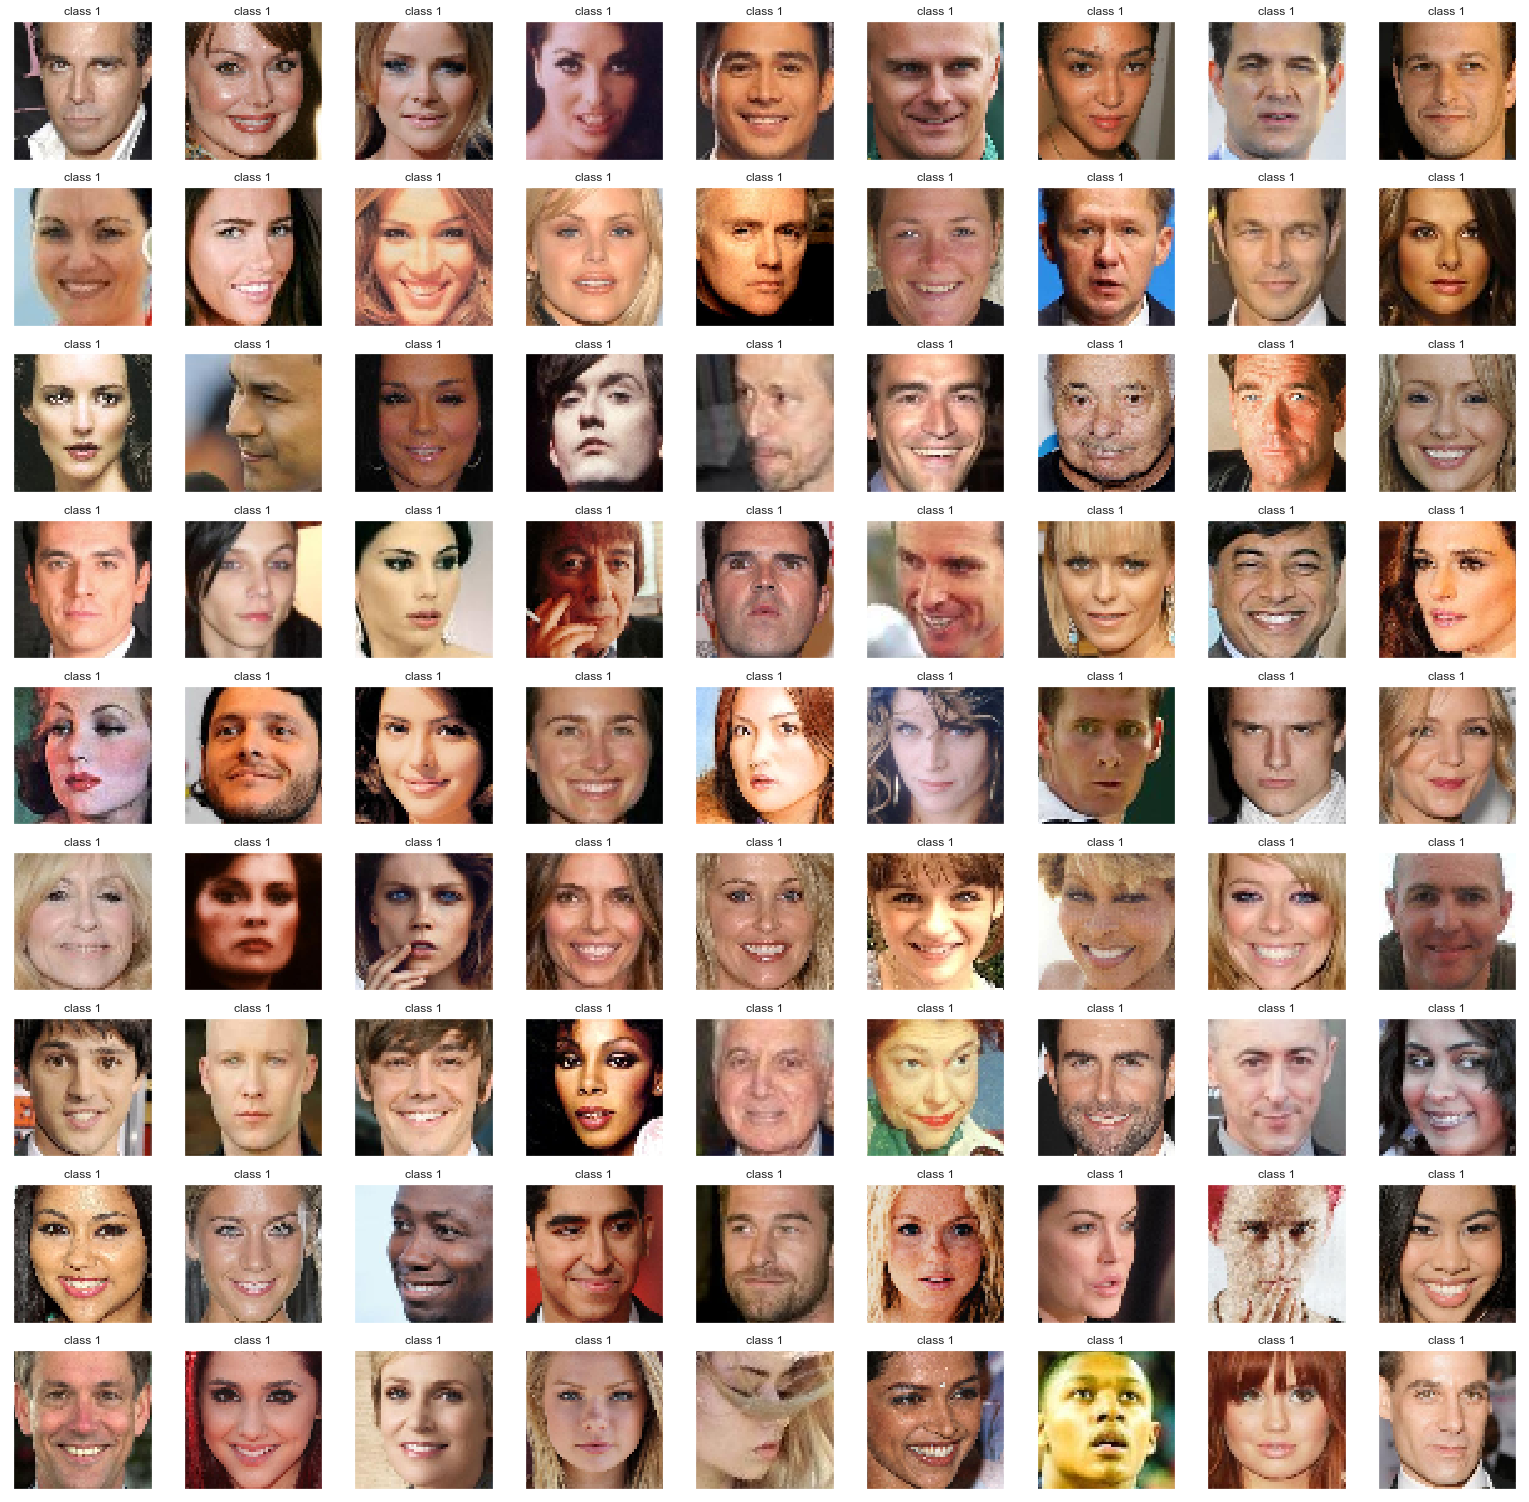

In [7]:
#Récupération des images pour les labels 0 et 1
for label in [0, 1]:
    printImagesFromLabel(label)

#### Interpretation des images  
On remarques que nos images relatives au premier label (0) correspondent au visages ayant des accessoires (chapeau, foulard, colier, barbes...), tandis que celles associées au second label (1) n'en n'ont aucuns. Par conséquent, on peut se baser sur ces critères pour classifier nos images, c'est à dire: 
- Images négatives (Label = 0) : Images avec des accessoires   
- Images positives (Label = 1) : Images sans accessoires  

#### Pourcentage de la repartition des images dans notre base d'entrainement.  
Nous allons analyser la distribution des images par label dans notre base d'entrainement afin de voir si elle est équilibrée ou pas.  


In [8]:
train_label_POSITIVE = train_images_label[train_images_label==1]
NB_train_POSITIVE = len(train_label_POSITIVE)

train_label_NEGATIVE = train_images_label[train_images_label==0]
NB_train_NEGATIVE = len(train_label_NEGATIVE)

print("- Nombre Labels positifs : {:d} ==> {:.2f} %".format(NB_train_POSITIVE, 100*NB_train_POSITIVE/num_train_images))
print("- Nombre Labels négatifs  : {:d} ==> {:.2f} %".format(NB_train_NEGATIVE, 100*NB_train_NEGATIVE/num_train_images))

- Nombre Labels positifs : 96180 ==> 86.31 %
- Nombre Labels négatifs  : 15250 ==> 13.69 %


#### Analyse de la distribution  
On remarque quand même que la distribution n'est pas du tout équilibrée, car nous avons une grande partie de la base associée aux images positives (Label = 1, avec 86.31%). Cela peut être problématique lors de la phase d'apprentissage de notre modèle de classification, car il peut être soumis à du Overfitting, c'est à dire de "l'apprentissage par coeur", parce qu'il ne se baserait que sur la repartition des exemples dans notre base pour associer le label de la classe majoritaire (label 1) à une nouvelle image lors de la classification de celle-ci.  
Pour remédier à ce problème nous allons équilibrer la repartition des exemples dans notre base d'entrainement. L'une des méthodes permettant de faire celà s'appelle le **Under Sampling**(http://www.chioka.in/class-imbalance-problem/).  

#### Application de la méthode du Under Sampling à notre base d'entrainement.  

In [9]:
RandUS = RandomUnderSampler(ratio='auto', random_state=0)
X_US, y_US = RandUS.fit_sample(train_images_data, train_images_label)

###### a- Nouvelle distribution après le Under Sampling

In [10]:
train_label_POSITIVE = y_US[y_US==1]
NB_train_POSITIVE = len(train_label_POSITIVE)

train_label_NEGEGATIVE = y_US[y_US==0]
NB_train_NEGATIVE = len(train_label_NEGEGATIVE)

print("- Nombre Labels positifs : {:d} ==> {:.2f} %".format(NB_train_POSITIVE, 100*NB_train_POSITIVE/len(y_US)))
print("- Nombre Labels négatifs  : {:d} ==> {:.2f} %".format(NB_train_NEGATIVE, 100*NB_train_NEGATIVE/len(y_US)))


- Nombre Labels positifs : 15250 ==> 50.00 %
- Nombre Labels négatifs  : 15250 ==> 50.00 %


La méthode du under sampling nous donne clairement une distribution équitable (50% / 50%) de nos images en fonction des labels.  

#### Vérification de la taille de nos données après le Under Sampling

In [11]:
print("Informations apres le Under Sampling. ")
print("- Train Under sampling  :", X_US.shape)
print("- Labels Under Sampling :", y_US.shape)

Informations apres le Under Sampling. 
- Train Under sampling  : (30500, 9408)
- Labels Under Sampling : (30500,)


### D- Encodage One Hot de nos labels  
Le modèle utilisé exige l'utilisation de cette méthode d'encodage des labels. Pour ce faire, nous avons dans :  
- La première colonne : Les labels 0
- La séconde colonne : Les labels 1

In [12]:
#Nombre de classe correspondant à notre classification
C = 2
Y = y_US.astype(int)
y_US_encoded = np.eye(C)[Y.reshape(-1)]

In [13]:
print("Forme Label en Train après encodage :", y_US_encoded.shape)

Forme Label en Train après encodage : (30500, 2)


### E - Normalisation de notre base et séparation en  deux bases de données
Nous allons repartir notre base de données en deux sous-bases, à savoir: 
- Une base d'entrainement:  pour entrainer notre modèle.
- Une base de test : pour évaluer la capacité de généralisation de notre modèle.  

##### Separation  
La normalisation nous permetttra d'avoir des valeurs comprises entre 0 et 1, ce qui nous permettra d'avoir une convergence plus rapide lors de nos calculs.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_US, y_US_encoded,
                                                    test_size=0.05, shuffle=True, random_state=42)

##### Normalisation  
La normalisation nous permetttra d'avoir des valeurs comprises entre 0 et 1, ce qui nous permettra d'avoir une convergence plus rapide lors de nos calculs.

In [15]:
X_train = np.divide(X_train, 255., dtype=float)
X_test = np.divide(X_test, 255., dtype=float)

##### Verification des tailles

In [16]:
print("Informations sur nos nouvelles bases de données.")
print("- Train  :", X_train.shape)
print("- Test  :", X_test.shape)
print("- Labels Train  :", y_train.shape)
print("- Labels Test :", y_test.shape)

Informations sur nos nouvelles bases de données.
- Train  : (28975, 9408)
- Test  : (1525, 9408)
- Labels Train  : (28975, 2)
- Labels Test : (1525, 2)


##### Tableau issu du "one hot encoding"  
Comme évoqué précédemment, nous avons obtenu pour les labels, un tableau dans lequel, la première colonne correspond aux labels négatifs (0), et la séconde colonne correspond aux labels positifs (1). Cette illustration est donnée via le tableau ci-dessous.  

In [17]:
tableau_Label = pd.DataFrame(data =y_test, index= np.arange(1, len(y_test)+1),columns = ['Label 0','Label 1'])
                       
tableau_Label.head()

,Label 0,Label 1
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
5,0.0,1.0


##### Visualisation de l'éffet de la normalisation  sur nos bases d'entrainement et de test.  


In [18]:
# sur la base d'entrainement (X_train)
print("Base de Train:\n",X_train)
print("=========================================================================")

# sur la base de test (X_test)
print("Base de Test:\n",X_test)

Base de Train:
 [[0.68235294 0.09803922 0.0627451  ... 0.83137255 0.79607843 0.76078431]
 [0.52941176 0.51372549 0.3254902  ... 0.62745098 0.69019608 0.65098039]
 [0.1372549  0.05098039 0.03529412 ... 0.08235294 0.09019608 0.08627451]
 ...
 [0.15686275 0.15294118 0.17647059 ... 0.10588235 0.12156863 0.13333333]
 [0.11764706 0.04313725 0.02745098 ... 0.05490196 0.04313725 0.02352941]
 [0.7372549  0.63529412 0.49019608 ... 0.         0.         0.        ]]
Base de Test:
 [[0.42352941 0.08627451 0.09019608 ... 0.12941176 0.11764706 0.09803922]
 [0.06666667 0.07058824 0.09019608 ... 0.90196078 0.78039216 0.70196078]
 [0.         0.         0.         ... 0.2627451  0.12941176 0.03921569]
 ...
 [0.02745098 0.02745098 0.12156863 ... 0.00392157 0.         0.07058824]
 [0.22352941 0.18431373 0.17647059 ... 0.37254902 0.30588235 0.36862745]
 [0.26666667 0.23921569 0.16470588 ... 0.08235294 0.08627451 0.09411765]]


On voit clairement que la valeur prise par chacuns des pixels de nos images sont toutes comprises entre 0 et 1.

# PARTIE II: CONSTRUCTION DE L'ARCHITECTURE DE NOTRE RESEAU DE CONVOLUTION AVEC TENSORFLOW.  

## Les fonctions de la couche de convolution.

In [19]:
def fc(tensor, output_dim, IsTrainingMode, name, KP_dropout, act=tf.nn.relu):
    with tf.name_scope(name):
        input_dim = tensor.get_shape()[1].value
        Winit = tf.truncated_normal([input_dim, output_dim], stddev=np.sqrt(2.0/input_dim))
        W = tf.Variable(Winit)
        tf.add_to_collection(tf.GraphKeys.WEIGHTS, W)
        print (name,'input  ',tensor)
        print (name,'W  ',W.get_shape())
        #Binit = tf.constant(0.0, shape=[output_dim])  # Avec la BatchNorm, plus besoin de B
        #B = tf.Variable(Binit)
        tensor = tf.matmul(tensor, W) # + B
        tensor = tf.layers.batch_normalization(tensor, axis=-1, training=IsTrainingMode, trainable=True)
        tensor = act(tensor)
        if KP_dropout != 1.0:
            tensor = tf.cond(IsTrainingMode,lambda: tf.nn.dropout(tensor, KP_dropout), lambda: tf.identity(tensor))
    return tensor


def conv(tensor, outDim, filterSize, stride, IsTrainingMode, name, KP_dropout, act=tf.nn.relu):
    with tf.name_scope(name):
        inDimH = tensor.get_shape()[1].value
        inDimW = tensor.get_shape()[2].value
        inDimD = tensor.get_shape()[3].value
        Winit = tf.truncated_normal([filterSize, filterSize, inDimD, outDim], stddev=np.sqrt(2.0/(inDimH*inDimW*inDimD)))
        W = tf.Variable(Winit)
        tf.add_to_collection(tf.GraphKeys.WEIGHTS, W)
        print (name, 'input  ', tensor)
        print (name, 'W  ', W.get_shape())
        #Binit = tf.constant(0.0, shape=[outDim])  # Avec la BatchNorm, plus besoin de B
        #B = tf.Variable(Binit)
        tensor = tf.nn.conv2d(tensor, W, strides=[1, stride, stride, 1], padding='SAME') # + B
        tensor = tf.layers.batch_normalization(tensor, axis=-1, training=IsTrainingMode, trainable=True)
        tensor = act(tensor)
        if KP_dropout != 1.0:
            tensor = tf.cond(IsTrainingMode,lambda: tf.nn.dropout(tensor, KP_dropout), lambda: tf.identity(tensor))
    return tensor


def maxpool(tensor, poolSize, name):
    with tf.name_scope(name):
        tensor = tf.nn.max_pool(tensor, ksize=(1,poolSize,poolSize,1), strides=(1,poolSize,poolSize,1), padding='SAME')
    return tensor


def flat(tensor):
    tensor = tf.layers.flatten(tensor, name=None)
    print ('flat output  ', tensor)
    return tensor


def unflat(tensor, outDimH,outDimW,outDimD):
    tensor = tf.reshape(tensor, [-1,outDimH,outDimW,outDimD])
    print ('unflat output  ', tensor)
    return tensor

In [20]:
tf.reset_default_graph()

# Parameters to tune
learn_rate = 3e-3
KeepProb_Dropout = 0.8
L2_reg = 0.001

# Parameters of the model
nb_block = 4
nb_conv_per_block = 2
nbfilter_ini = 10


with tf.name_scope('input'):
    dim = 9408  # =(56*56*3)
    x = tf.placeholder(tf.float32, [None, dim], name='x')
    y_true = tf.placeholder(tf.float32, [None, 2], name='y_true')
    ITM = tf.placeholder("bool", name='Is_Training_Mode')

with tf.name_scope('CNN'):
    t = unflat(x,56,56,3) 
    nbfilter = nbfilter_ini
    for k in range(nb_block):
        for i in range(nb_conv_per_block):
            t = conv(t, outDim=nbfilter, filterSize=3, stride=1, IsTrainingMode=ITM,
                            name='conv_%d_%d'%(nbfilter,i), KP_dropout=KeepProb_Dropout)
        t = maxpool(t, poolSize=2, name='pool')
        nbfilter *= 2
    
    t = flat(t)
    t = fc(t,256, ITM, 'fc_0', KeepProb_Dropout, act=tf.nn.relu)
    t = fc(t, 64, ITM, 'fc_1', KP_dropout = 0.9, act=tf.nn.relu)
    z = fc(t,  2, ITM, 'fc_2', KP_dropout=1.0,   act=tf.identity)


with tf.name_scope('cost_function'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=z, labels=y_true))
    l2_loss = L2_reg * tf.add_n( [tf.nn.l2_loss(w) for w in tf.get_collection(tf.GraphKeys.WEIGHTS)] )
    cost_func = cross_entropy + l2_loss
    tf.summary.scalar('cost_func', cost_func)

with tf.name_scope('metrics'):
    y_true_vector = tf.cast(tf.argmax(y_true, axis=1), tf.float32)
    y_pred_vector = tf.cast(tf.argmax(z, axis=1), tf.float32)
    with tf.name_scope('score_Challenge'):
        N0 = tf.reduce_sum(tf.cast(tf.equal(y_true_vector, 0), tf.float32))
        N1 = tf.reduce_sum(tf.cast(tf.equal(y_true_vector, 1), tf.float32))
        score_chall = 0.5 * (tf.reduce_sum((1-y_true_vector)*(1-y_pred_vector))/N0 \
                             + tf.reduce_sum(y_true_vector*y_pred_vector)/N1)
        tf.summary.scalar('score_challenge', score_chall)

with tf.name_scope('learning_rate'):
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learn_rate, global_step, decay_steps=200, decay_rate=0.9, staircase=True)
    tf.summary.scalar('learning_rate', learning_rate)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost_func, global_step=global_step)

merged = tf.summary.merge_all()

unflat output   Tensor("CNN/Reshape:0", shape=(?, 56, 56, 3), dtype=float32)
conv_10_0 input   Tensor("CNN/Reshape:0", shape=(?, 56, 56, 3), dtype=float32)
conv_10_0 W   (3, 3, 3, 10)
conv_10_1 input   Tensor("CNN/conv_10_0/cond/Merge:0", shape=(?, 56, 56, 10), dtype=float32)
conv_10_1 W   (3, 3, 10, 10)
conv_20_0 input   Tensor("CNN/pool/MaxPool:0", shape=(?, 28, 28, 10), dtype=float32)
conv_20_0 W   (3, 3, 10, 20)
conv_20_1 input   Tensor("CNN/conv_20_0/cond/Merge:0", shape=(?, 28, 28, 20), dtype=float32)
conv_20_1 W   (3, 3, 20, 20)
conv_40_0 input   Tensor("CNN/pool_1/MaxPool:0", shape=(?, 14, 14, 20), dtype=float32)
conv_40_0 W   (3, 3, 20, 40)
conv_40_1 input   Tensor("CNN/conv_40_0/cond/Merge:0", shape=(?, 14, 14, 40), dtype=float32)
conv_40_1 W   (3, 3, 40, 40)
conv_80_0 input   Tensor("CNN/pool_2/MaxPool:0", shape=(?, 7, 7, 40), dtype=float32)
conv_80_0 W   (3, 3, 40, 80)
conv_80_1 input   Tensor("CNN/conv_80_0/cond/Merge:0", shape=(?, 7, 7, 80), dtype=float32)
conv_80_1 W   (

# PARTIE III: ENTRAINEMENT DE NOTRE MODEL  
Afin de bien mener cette étape, la définition de deux fonctions importantes est indispensable. Ces fonction sont: 
- train_model : Servant à entrainer notre réseau de convolution.  
- create_random_mini_batches : Sert à créer des minibatches à partir du couple (X,Y)  

Ensuite, nous allons lancer notre entrainement avec 150 epochs, et le modèle sera sauvegardé à la fin de chacun des epochs.

In [21]:
def create_random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, input size)
    Y -- true "label", of shape (number of examples, 2)
    mini_batch_size - size of the mini-batches, integer
    seed -- to set the randomness
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]     # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size) # number of mini batches of size mini_batch_size in (X, Y)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [22]:
def train_model(experiment_name_base, experiment_name, X_train, y_train, X_test, y_test,
                minibatch_size=256, num_epochs_to_run=1, epoch_start=0, it_start=0, print_cost=True):
    
    print ("-------    ", experiment_name, "  -------\n")
    it = it_start
    
    sess = tf.Session()
    saver = tf.train.Saver(max_to_keep=None)  # by default, tf keeps only the 5 last models
    
    if epoch_start == 0:
        sess.run(tf.global_variables_initializer())
    else:
        saver.restore(sess, experiment_name)
    
    writer = tf.summary.FileWriter(experiment_name_base, sess.graph)
    
    score_train_history = []
    score_test_history = []
    
    for epoch in range(num_epochs_to_run):
        
        t0 = time()
        seed = epoch_start + epoch + 1  # at each epoch, set a different seed (to split differently into minibatches)
        minibatches = create_random_mini_batches(X_train, y_train, minibatch_size, seed)
        
        for minibatch in minibatches:
            
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            trainDict = {x:minibatch_X, y_true:minibatch_Y, ITM:True}
            
            # Run a gradient descent step on a minibatch
            sess.run(train_step, feed_dict=trainDict)
            it += 1
            
            # Print informations every 10 iterations
            if print_cost == True and it % 10 == 0:
                cost, sco, lr = sess.run([cost_func, score_chall, learning_rate], feed_dict=trainDict)
                n0 = np.sum(trainDict[y_true][:,0])
                n1 = np.sum(trainDict[y_true][:,1])
                print("iteration= %6d | rate= %f | cost= %f | score= %f | (#0=%d - #1=%d)" % (it, lr, cost, sco, n0, n1))
                
                # Write (Cost, LearningRate, Score) in tensorboard
                summary_merged = sess.run(merged, feed_dict=trainDict)
                writer.add_summary(summary_merged, it)
        
        if print_cost == True:
            # Compute Train Score using minibatches
            t = time()
            sco_train = 0
            m = y_train.shape[0]
            for minibatch in minibatches:
                # select a mini-batch
                (minibatch_X, minibatch_Y) = minibatch                
                trainDict = {x:minibatch_X, y_true:minibatch_Y, ITM:False}
                # compute score on current mini-batch and add it to the total
                sco_tmp = sess.run(score_chall, feed_dict=trainDict)
                sco_train += sco_tmp
            sco_train = sco_train / (m/minibatch_size)
            # Keep track of train score
            score_train_history.append(sco_train)
            print ("Train Score: %.6f"%sco_train, "    time=%.3f"%(time()-t))
            
            # Compute Test Score using .eval  (works only for small dataset to evaluate)
            t = time()
            sco_test = score_chall.eval({x: X_test, y_true: y_test, ITM:False}, session=sess)
            # Keep track of test score
            score_test_history.append(sco_test)
            print ("Test Score : %.6f"%sco_test, "    time=%.3f"%(time()-t))
            
            print ("     Execution time after epoch %2d : %.3f (sec)\n" % (epoch_start+epoch+1, time()-t0))
        
        # At the end of each epoch, save the model
        saver.save(sess, experiment_name_base+"_epoch_%d"%(epoch_start+epoch+1))
        
    print("last iteration =", it)
    print("last epoch =", epoch_start+epoch+1)
    print()
    writer.close()
    sess.close()
    
    return it, epoch_start+epoch+1, score_train_history, score_test_history

### Lancement de l'entrainement  
Le bloc de code ci-dessous permet de lancer l'entrainement de notre modèle en fonction des éléments ci-dessous:  
- La taille du batch  
- Le nombre d'epoch 
- Le début de l'epoch  
- Le debut de l'itération  

In [23]:
minibatch_size = 256
num_epochs_to_run = 200
epoch_start = 0
it_start = 0

experiment_name_base = "./resultats_modeles/Model_KeepPD%.2f_MBSize%d_NbBlock%d_ConvPerB%d_NbFilter%d_Learn_R%.4f_L2Rg-%.3f.ckpt" % \
                    (KeepProb_Dropout, minibatch_size, nb_block, nb_conv_per_block, nbfilter_ini, learn_rate, L2_reg)
experiment_name = experiment_name_base

#  ENTRAINER LE MODELE
last_it, last_epoch, historique_score_train_with_200_epochs, historique_score_test_with_200_epochs = train_model(experiment_name_base,
                                                                                                             experiment_name,
                                                                                                             X_train, y_train,
                                                                                                             X_test, y_test,
                                                                                                             minibatch_size,
                                                                                                             num_epochs_to_run,
                                                                                                             epoch_start,
                                                                                                             it_start,
                                                                                                             print_cost = True)

np.savetxt("./historique/historique_score_train_with_200_epochs.txt", historique_score_train_with_200_epochs)
np.savetxt("./historique/istorique_score_test_with_200_epochs.txt", historique_score_test_with_200_epochs)

-------     ./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt   -------

iteration=     10 | rate= 0.003000 | cost= 0.902098 | score= 0.646195 | (#0=122 - #1=134)
iteration=     20 | rate= 0.003000 | cost= 0.822641 | score= 0.741690 | (#0=121 - #1=135)
iteration=     30 | rate= 0.003000 | cost= 0.789194 | score= 0.746726 | (#0=142 - #1=114)
iteration=     40 | rate= 0.003000 | cost= 0.646479 | score= 0.828922 | (#0=120 - #1=136)
iteration=     50 | rate= 0.003000 | cost= 0.630748 | score= 0.789046 | (#0=133 - #1=123)
iteration=     60 | rate= 0.003000 | cost= 0.579697 | score= 0.852214 | (#0=125 - #1=131)
iteration=     70 | rate= 0.003000 | cost= 0.588925 | score= 0.859740 | (#0=118 - #1=138)
iteration=     80 | rate= 0.003000 | cost= 0.482198 | score= 0.897671 | (#0=123 - #1=133)
iteration=     90 | rate= 0.003000 | cost= 0.484126 | score= 0.878938 | (#0=126 - #1=130)
iteration=    100 | rate= 0.003000 | cost= 0.462258 | score=

iteration=    700 | rate= 0.002187 | cost= 0.233955 | score= 0.929500 | (#0=127 - #1=129)
iteration=    710 | rate= 0.002187 | cost= 0.279992 | score= 0.911210 | (#0=112 - #1=144)
iteration=    720 | rate= 0.002187 | cost= 0.264656 | score= 0.912034 | (#0=114 - #1=142)
iteration=    730 | rate= 0.002187 | cost= 0.200903 | score= 0.951423 | (#0=117 - #1=139)
iteration=    740 | rate= 0.002187 | cost= 0.261695 | score= 0.918198 | (#0=131 - #1=125)
iteration=    750 | rate= 0.002187 | cost= 0.239125 | score= 0.929832 | (#0=131 - #1=125)
iteration=    760 | rate= 0.002187 | cost= 0.276760 | score= 0.916468 | (#0=133 - #1=123)
iteration=    770 | rate= 0.002187 | cost= 0.248107 | score= 0.922623 | (#0=138 - #1=118)
iteration=    780 | rate= 0.002187 | cost= 0.251285 | score= 0.926535 | (#0=134 - #1=122)
iteration=    790 | rate= 0.002187 | cost= 0.322097 | score= 0.874379 | (#0=137 - #1=119)
Train Score: 0.871664     time=60.155
Test Score : 0.862307     time=3.029
     Execution time after

iteration=   1400 | rate= 0.001435 | cost= 0.215833 | score= 0.933578 | (#0=120 - #1=136)
iteration=   1410 | rate= 0.001435 | cost= 0.236059 | score= 0.932326 | (#0=118 - #1=138)
iteration=   1420 | rate= 0.001435 | cost= 0.205345 | score= 0.929905 | (#0=121 - #1=135)
iteration=   1430 | rate= 0.001435 | cost= 0.228198 | score= 0.925689 | (#0=119 - #1=137)
iteration=   1440 | rate= 0.001435 | cost= 0.222823 | score= 0.928357 | (#0=133 - #1=123)
iteration=   1450 | rate= 0.001435 | cost= 0.240542 | score= 0.914607 | (#0=134 - #1=122)
iteration=   1460 | rate= 0.001435 | cost= 0.292063 | score= 0.917937 | (#0=135 - #1=121)
iteration=   1470 | rate= 0.001435 | cost= 0.240456 | score= 0.919147 | (#0=113 - #1=143)
iteration=   1480 | rate= 0.001435 | cost= 0.164470 | score= 0.968750 | (#0=128 - #1=128)
Train Score: 0.864240     time=59.441
Test Score : 0.849455     time=3.036
     Execution time after epoch 13 : 548.757 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_

iteration=   2100 | rate= 0.001046 | cost= 0.237319 | score= 0.926355 | (#0=116 - #1=140)
iteration=   2110 | rate= 0.001046 | cost= 0.169128 | score= 0.952939 | (#0=129 - #1=127)
iteration=   2120 | rate= 0.001046 | cost= 0.219596 | score= 0.944151 | (#0=137 - #1=119)
iteration=   2130 | rate= 0.001046 | cost= 0.224438 | score= 0.929902 | (#0=136 - #1=120)
iteration=   2140 | rate= 0.001046 | cost= 0.218449 | score= 0.948976 | (#0=113 - #1=143)
iteration=   2150 | rate= 0.001046 | cost= 0.239067 | score= 0.924020 | (#0=136 - #1=120)
iteration=   2160 | rate= 0.001046 | cost= 0.175548 | score= 0.956867 | (#0=132 - #1=124)
Train Score: 0.924183     time=60.009
Test Score : 0.902620     time=3.115
     Execution time after epoch 19 : 546.705 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_19 is not in all_model_checkpoint_paths. Manually adding it.
iteration=   2170 | rate= 0.001046 | cost= 0.269277 |

iteration=   2800 | rate= 0.000686 | cost= 0.210783 | score= 0.923589 | (#0=133 - #1=123)
iteration=   2810 | rate= 0.000686 | cost= 0.228128 | score= 0.927910 | (#0=142 - #1=114)
iteration=   2820 | rate= 0.000686 | cost= 0.219542 | score= 0.929890 | (#0=119 - #1=137)
iteration=   2830 | rate= 0.000686 | cost= 0.167531 | score= 0.945492 | (#0=127 - #1=129)
iteration=   2840 | rate= 0.000686 | cost= 0.126157 | score= 0.972366 | (#0=125 - #1=131)
iteration=   2850 | rate= 0.000686 | cost= 0.147634 | score= 0.957428 | (#0=24 - #1=23)
Train Score: 0.933410     time=59.579
Test Score : 0.909757     time=3.108
     Execution time after epoch 25 : 547.293 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_25 is not in all_model_checkpoint_paths. Manually adding it.
iteration=   2860 | rate= 0.000686 | cost= 0.177131 | score= 0.945431 | (#0=127 - #1=129)
iteration=   2870 | rate= 0.000686 | cost= 0.199001 | s

iteration=   3500 | rate= 0.000500 | cost= 0.163062 | score= 0.957120 | (#0=134 - #1=122)
iteration=   3510 | rate= 0.000500 | cost= 0.226572 | score= 0.928075 | (#0=144 - #1=112)
iteration=   3520 | rate= 0.000500 | cost= 0.148194 | score= 0.960996 | (#0=127 - #1=129)
iteration=   3530 | rate= 0.000500 | cost= 0.173189 | score= 0.952984 | (#0=121 - #1=135)
Train Score: 0.913163     time=58.935
Test Score : 0.893452     time=3.175
     Execution time after epoch 31 : 547.663 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_31 is not in all_model_checkpoint_paths. Manually adding it.
iteration=   3540 | rate= 0.000500 | cost= 0.190627 | score= 0.942730 | (#0=121 - #1=135)
iteration=   3550 | rate= 0.000500 | cost= 0.128155 | score= 0.976295 | (#0=124 - #1=132)
iteration=   3560 | rate= 0.000500 | cost= 0.138917 | score= 0.964652 | (#0=130 - #1=126)
iteration=   3570 | rate= 0.000500 | cost= 0.153000 |

iteration=   4200 | rate= 0.000328 | cost= 0.158616 | score= 0.949219 | (#0=128 - #1=128)
iteration=   4210 | rate= 0.000328 | cost= 0.209492 | score= 0.922623 | (#0=138 - #1=118)
Train Score: 0.928802     time=59.099
Test Score : 0.896783     time=3.222
     Execution time after epoch 37 : 546.355 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_37 is not in all_model_checkpoint_paths. Manually adding it.
iteration=   4220 | rate= 0.000328 | cost= 0.144601 | score= 0.965248 | (#0=133 - #1=123)
iteration=   4230 | rate= 0.000328 | cost= 0.148348 | score= 0.953444 | (#0=137 - #1=119)
iteration=   4240 | rate= 0.000328 | cost= 0.172683 | score= 0.945299 | (#0=126 - #1=130)
iteration=   4250 | rate= 0.000328 | cost= 0.174356 | score= 0.926432 | (#0=133 - #1=123)
iteration=   4260 | rate= 0.000328 | cost= 0.128703 | score= 0.961275 | (#0=136 - #1=120)
iteration=   4270 | rate= 0.000328 | cost= 0.135943 |

iteration=   4900 | rate= 0.000239 | cost= 0.157473 | score= 0.952941 | (#0=136 - #1=120)
Train Score: 0.934475     time=60.371
Test Score : 0.903247     time=3.124
     Execution time after epoch 43 : 559.330 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_43 is not in all_model_checkpoint_paths. Manually adding it.
iteration=   4910 | rate= 0.000239 | cost= 0.144575 | score= 0.964733 | (#0=125 - #1=131)
iteration=   4920 | rate= 0.000239 | cost= 0.141965 | score= 0.964689 | (#0=129 - #1=127)
iteration=   4930 | rate= 0.000239 | cost= 0.127470 | score= 0.960411 | (#0=132 - #1=124)
iteration=   4940 | rate= 0.000239 | cost= 0.138645 | score= 0.961218 | (#0=134 - #1=122)
iteration=   4950 | rate= 0.000239 | cost= 0.118974 | score= 0.960806 | (#0=130 - #1=126)
iteration=   4960 | rate= 0.000239 | cost= 0.100788 | score= 0.980286 | (#0=123 - #1=133)
iteration=   4970 | rate= 0.000239 | cost= 0.100368 |

iteration=   5590 | rate= 0.000174 | cost= 0.151091 | score= 0.952991 | (#0=126 - #1=130)
iteration=   5600 | rate= 0.000157 | cost= 0.140909 | score= 0.957356 | (#0=124 - #1=132)
iteration=   5610 | rate= 0.000157 | cost= 0.166184 | score= 0.960485 | (#0=122 - #1=134)
iteration=   5620 | rate= 0.000157 | cost= 0.133458 | score= 0.952288 | (#0=134 - #1=122)
iteration=   5630 | rate= 0.000157 | cost= 0.134675 | score= 0.960366 | (#0=131 - #1=125)
iteration=   5640 | rate= 0.000157 | cost= 0.136165 | score= 0.941470 | (#0=133 - #1=123)
iteration=   5650 | rate= 0.000157 | cost= 0.155013 | score= 0.952837 | (#0=138 - #1=118)
iteration=   5660 | rate= 0.000157 | cost= 0.092861 | score= 0.983582 | (#0=139 - #1=117)
iteration=   5670 | rate= 0.000157 | cost= 0.192301 | score= 0.952662 | (#0=153 - #1=103)
iteration=   5680 | rate= 0.000157 | cost= 0.163230 | score= 0.949600 | (#0=123 - #1=133)
iteration=   5690 | rate= 0.000157 | cost= 0.126191 | score= 0.972733 | (#0=125 - #1=131)
iteration=

iteration=   6290 | rate= 0.000114 | cost= 0.165199 | score= 0.945649 | (#0=125 - #1=131)
iteration=   6300 | rate= 0.000114 | cost= 0.135451 | score= 0.953389 | (#0=134 - #1=122)
iteration=   6310 | rate= 0.000114 | cost= 0.168436 | score= 0.941716 | (#0=132 - #1=124)
iteration=   6320 | rate= 0.000114 | cost= 0.142807 | score= 0.960684 | (#0=130 - #1=126)
iteration=   6330 | rate= 0.000114 | cost= 0.148011 | score= 0.953236 | (#0=126 - #1=130)
iteration=   6340 | rate= 0.000114 | cost= 0.118458 | score= 0.976878 | (#0=122 - #1=134)
iteration=   6350 | rate= 0.000114 | cost= 0.125496 | score= 0.964953 | (#0=121 - #1=135)
iteration=   6360 | rate= 0.000114 | cost= 0.123186 | score= 0.965018 | (#0=130 - #1=126)
iteration=   6370 | rate= 0.000114 | cost= 0.145129 | score= 0.949185 | (#0=127 - #1=129)
iteration=   6380 | rate= 0.000114 | cost= 0.124566 | score= 0.960938 | (#0=128 - #1=128)
Train Score: 0.966320     time=59.170
Test Score : 0.917291     time=3.011
     Execution time after

iteration=   6990 | rate= 0.000083 | cost= 0.132712 | score= 0.960938 | (#0=128 - #1=128)
iteration=   7000 | rate= 0.000075 | cost= 0.134585 | score= 0.955482 | (#0=117 - #1=139)
iteration=   7010 | rate= 0.000075 | cost= 0.163898 | score= 0.939064 | (#0=117 - #1=139)
iteration=   7020 | rate= 0.000075 | cost= 0.105056 | score= 0.969314 | (#0=123 - #1=133)
iteration=   7030 | rate= 0.000075 | cost= 0.117916 | score= 0.972181 | (#0=118 - #1=138)
iteration=   7040 | rate= 0.000075 | cost= 0.130193 | score= 0.957120 | (#0=122 - #1=134)
iteration=   7050 | rate= 0.000075 | cost= 0.111178 | score= 0.972767 | (#0=123 - #1=133)
iteration=   7060 | rate= 0.000075 | cost= 0.129854 | score= 0.962250 | (#0=143 - #1=113)
Train Score: 0.970292     time=59.171
Test Score : 0.916419     time=3.105
     Execution time after epoch 62 : 546.272 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_62 is not in all_model_c

iteration=   7690 | rate= 0.000055 | cost= 0.109088 | score= 0.969085 | (#0=135 - #1=121)
iteration=   7700 | rate= 0.000055 | cost= 0.148261 | score= 0.956813 | (#0=133 - #1=123)
iteration=   7710 | rate= 0.000055 | cost= 0.143634 | score= 0.956185 | (#0=113 - #1=143)
iteration=   7720 | rate= 0.000055 | cost= 0.108635 | score= 0.973284 | (#0=136 - #1=120)
iteration=   7730 | rate= 0.000055 | cost= 0.110941 | score= 0.968626 | (#0=129 - #1=127)
iteration=   7740 | rate= 0.000055 | cost= 0.095590 | score= 0.976832 | (#0=123 - #1=133)
iteration=   7750 | rate= 0.000055 | cost= 0.150086 | score= 0.953125 | (#0=128 - #1=128)
Train Score: 0.973282     time=59.342
Test Score : 0.913791     time=2.991
     Execution time after epoch 68 : 548.558 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_68 is not in all_model_checkpoint_paths. Manually adding it.
iteration=   7760 | rate= 0.000055 | cost= 0.125169 |

iteration=   8390 | rate= 0.000040 | cost= 0.122486 | score= 0.957074 | (#0=118 - #1=138)
iteration=   8400 | rate= 0.000036 | cost= 0.127943 | score= 0.972740 | (#0=143 - #1=113)
iteration=   8410 | rate= 0.000036 | cost= 0.117258 | score= 0.973284 | (#0=120 - #1=136)
iteration=   8420 | rate= 0.000036 | cost= 0.116130 | score= 0.964950 | (#0=122 - #1=134)
iteration=   8430 | rate= 0.000036 | cost= 0.119584 | score= 0.957424 | (#0=123 - #1=133)
Train Score: 0.972182     time=61.447
Test Score : 0.910521     time=3.293
     Execution time after epoch 74 : 549.128 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_74 is not in all_model_checkpoint_paths. Manually adding it.
iteration=   8440 | rate= 0.000036 | cost= 0.135218 | score= 0.974261 | (#0=116 - #1=140)
iteration=   8450 | rate= 0.000036 | cost= 0.103763 | score= 0.968916 | (#0=131 - #1=125)
iteration=   8460 | rate= 0.000036 | cost= 0.131082 |

iteration=   9090 | rate= 0.000026 | cost= 0.078237 | score= 0.981404 | (#0=116 - #1=140)
iteration=   9100 | rate= 0.000026 | cost= 0.117054 | score= 0.966163 | (#0=118 - #1=138)
iteration=   9110 | rate= 0.000026 | cost= 0.138240 | score= 0.960851 | (#0=134 - #1=122)
iteration=   9120 | rate= 0.000026 | cost= 0.083337 | score= 0.981481 | (#0=20 - #1=27)
Train Score: 0.981685     time=59.217
Test Score : 0.914478     time=3.177
     Execution time after epoch 80 : 547.036 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_80 is not in all_model_checkpoint_paths. Manually adding it.
iteration=   9130 | rate= 0.000026 | cost= 0.109610 | score= 0.973775 | (#0=120 - #1=136)
iteration=   9140 | rate= 0.000026 | cost= 0.111806 | score= 0.968424 | (#0=115 - #1=141)
iteration=   9150 | rate= 0.000026 | cost= 0.073166 | score= 0.984252 | (#0=127 - #1=129)
iteration=   9160 | rate= 0.000026 | cost= 0.108651 | s

iteration=   9790 | rate= 0.000019 | cost= 0.087929 | score= 0.985915 | (#0=114 - #1=142)
iteration=   9800 | rate= 0.000017 | cost= 0.109528 | score= 0.968498 | (#0=130 - #1=126)
Train Score: 0.980696     time=59.333
Test Score : 0.913852     time=3.069
     Execution time after epoch 86 : 547.600 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_86 is not in all_model_checkpoint_paths. Manually adding it.
iteration=   9810 | rate= 0.000017 | cost= 0.079470 | score= 0.976557 | (#0=126 - #1=130)
iteration=   9820 | rate= 0.000017 | cost= 0.146506 | score= 0.955283 | (#0=106 - #1=150)
iteration=   9830 | rate= 0.000017 | cost= 0.101688 | score= 0.972624 | (#0=127 - #1=129)
iteration=   9840 | rate= 0.000017 | cost= 0.094189 | score= 0.988250 | (#0=127 - #1=129)
iteration=   9850 | rate= 0.000017 | cost= 0.119885 | score= 0.965549 | (#0=118 - #1=138)
iteration=   9860 | rate= 0.000017 | cost= 0.102872 |

Train Score: 0.983092     time=59.419
Test Score : 0.914540     time=3.103
     Execution time after epoch 92 : 546.507 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_92 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  10490 | rate= 0.000013 | cost= 0.094222 | score= 0.976527 | (#0=133 - #1=123)
iteration=  10500 | rate= 0.000013 | cost= 0.114431 | score= 0.975100 | (#0=108 - #1=148)
iteration=  10510 | rate= 0.000013 | cost= 0.095908 | score= 0.972767 | (#0=133 - #1=123)
iteration=  10520 | rate= 0.000013 | cost= 0.106747 | score= 0.964872 | (#0=127 - #1=129)
iteration=  10530 | rate= 0.000013 | cost= 0.110059 | score= 0.957031 | (#0=128 - #1=128)
iteration=  10540 | rate= 0.000013 | cost= 0.133249 | score= 0.963405 | (#0=111 - #1=145)
iteration=  10550 | rate= 0.000013 | cost= 0.088926 | score= 0.968809 | (#0=129 - #1=127)
iteration=  10560 | rate= 0.000013 | cost= 0.077731 |

iteration=  11180 | rate= 0.000009 | cost= 0.091982 | score= 0.980525 | (#0=126 - #1=130)
iteration=  11190 | rate= 0.000009 | cost= 0.085911 | score= 0.972767 | (#0=123 - #1=133)
iteration=  11200 | rate= 0.000008 | cost= 0.099867 | score= 0.968565 | (#0=127 - #1=129)
iteration=  11210 | rate= 0.000008 | cost= 0.101912 | score= 0.968550 | (#0=125 - #1=131)
iteration=  11220 | rate= 0.000008 | cost= 0.072621 | score= 0.992308 | (#0=126 - #1=130)
iteration=  11230 | rate= 0.000008 | cost= 0.105170 | score= 0.979167 | (#0=144 - #1=112)
iteration=  11240 | rate= 0.000008 | cost= 0.074007 | score= 0.984115 | (#0=132 - #1=124)
iteration=  11250 | rate= 0.000008 | cost= 0.105387 | score= 0.972711 | (#0=126 - #1=130)
iteration=  11260 | rate= 0.000008 | cost= 0.124087 | score= 0.969619 | (#0=123 - #1=133)
iteration=  11270 | rate= 0.000008 | cost= 0.110324 | score= 0.969697 | (#0=132 - #1=124)
iteration=  11280 | rate= 0.000008 | cost= 0.081521 | score= 0.984115 | (#0=132 - #1=124)
Train Scor

iteration=  11880 | rate= 0.000006 | cost= 0.098405 | score= 0.980286 | (#0=133 - #1=123)
iteration=  11890 | rate= 0.000006 | cost= 0.121347 | score= 0.965099 | (#0=125 - #1=131)
iteration=  11900 | rate= 0.000006 | cost= 0.077217 | score= 0.984708 | (#0=122 - #1=134)
iteration=  11910 | rate= 0.000006 | cost= 0.090986 | score= 0.979767 | (#0=135 - #1=121)
iteration=  11920 | rate= 0.000006 | cost= 0.117936 | score= 0.958754 | (#0=113 - #1=143)
iteration=  11930 | rate= 0.000006 | cost= 0.104555 | score= 0.973900 | (#0=137 - #1=119)
iteration=  11940 | rate= 0.000006 | cost= 0.083191 | score= 0.980498 | (#0=127 - #1=129)
iteration=  11950 | rate= 0.000006 | cost= 0.123438 | score= 0.974376 | (#0=141 - #1=115)
iteration=  11960 | rate= 0.000006 | cost= 0.118714 | score= 0.966853 | (#0=145 - #1=111)
iteration=  11970 | rate= 0.000006 | cost= 0.057757 | score= 1.000000 | (#0=22 - #1=25)
Train Score: 0.985541     time=59.050
Test Score : 0.915609     time=3.078
     Execution time after e

iteration=  12580 | rate= 0.000004 | cost= 0.087580 | score= 0.972955 | (#0=130 - #1=126)
iteration=  12590 | rate= 0.000004 | cost= 0.090871 | score= 0.973900 | (#0=119 - #1=137)
iteration=  12600 | rate= 0.000004 | cost= 0.086273 | score= 0.984657 | (#0=133 - #1=123)
iteration=  12610 | rate= 0.000004 | cost= 0.090118 | score= 0.972624 | (#0=129 - #1=127)
iteration=  12620 | rate= 0.000004 | cost= 0.084866 | score= 0.984493 | (#0=130 - #1=126)
iteration=  12630 | rate= 0.000004 | cost= 0.076749 | score= 0.988636 | (#0=124 - #1=132)
iteration=  12640 | rate= 0.000004 | cost= 0.097619 | score= 0.977245 | (#0=134 - #1=122)
iteration=  12650 | rate= 0.000004 | cost= 0.100983 | score= 0.964950 | (#0=134 - #1=122)
Train Score: 0.983779     time=58.886
Test Score : 0.911911     time=3.095
     Execution time after epoch 111 : 547.831 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_111 is not in all_model

iteration=  13280 | rate= 0.000003 | cost= 0.084006 | score= 0.981270 | (#0=118 - #1=138)
iteration=  13290 | rate= 0.000003 | cost= 0.068133 | score= 0.992164 | (#0=121 - #1=135)
iteration=  13300 | rate= 0.000003 | cost= 0.078792 | score= 0.984375 | (#0=128 - #1=128)
iteration=  13310 | rate= 0.000003 | cost= 0.082580 | score= 0.980147 | (#0=136 - #1=120)
iteration=  13320 | rate= 0.000003 | cost= 0.107363 | score= 0.968558 | (#0=138 - #1=118)
iteration=  13330 | rate= 0.000003 | cost= 0.073750 | score= 0.992754 | (#0=118 - #1=138)
Train Score: 0.984768     time=60.730
Test Score : 0.913164     time=3.236
     Execution time after epoch 117 : 569.869 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_117 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  13340 | rate= 0.000003 | cost= 0.076494 | score= 0.988392 | (#0=124 - #1=132)
iteration=  13350 | rate= 0.000003 | cost= 0.078694

iteration=  13980 | rate= 0.000002 | cost= 0.082548 | score= 0.984375 | (#0=128 - #1=128)
iteration=  13990 | rate= 0.000002 | cost= 0.092268 | score= 0.974376 | (#0=141 - #1=115)
iteration=  14000 | rate= 0.000002 | cost= 0.114785 | score= 0.972788 | (#0=135 - #1=121)
iteration=  14010 | rate= 0.000002 | cost= 0.087086 | score= 0.976744 | (#0=127 - #1=129)
iteration=  14020 | rate= 0.000002 | cost= 0.090242 | score= 0.980242 | (#0=134 - #1=122)
Train Score: 0.984362     time=60.963
Test Score : 0.913164     time=3.215
     Execution time after epoch 123 : 561.242 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_123 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  14030 | rate= 0.000002 | cost= 0.078273 | score= 0.980376 | (#0=129 - #1=127)
iteration=  14040 | rate= 0.000002 | cost= 0.082280 | score= 0.988072 | (#0=122 - #1=134)
iteration=  14050 | rate= 0.000002 | cost= 0.104768

iteration=  14680 | rate= 0.000001 | cost= 0.128292 | score= 0.949405 | (#0=112 - #1=144)
iteration=  14690 | rate= 0.000001 | cost= 0.113440 | score= 0.976561 | (#0=129 - #1=127)
iteration=  14700 | rate= 0.000001 | cost= 0.095323 | score= 0.972711 | (#0=130 - #1=126)
Train Score: 0.984782     time=60.444
Test Score : 0.913103     time=3.150
     Execution time after epoch 129 : 556.608 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_129 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  14710 | rate= 0.000001 | cost= 0.064699 | score= 0.992157 | (#0=136 - #1=120)
iteration=  14720 | rate= 0.000001 | cost= 0.129690 | score= 0.975694 | (#0=144 - #1=112)
iteration=  14730 | rate= 0.000001 | cost= 0.084721 | score= 0.989209 | (#0=139 - #1=117)
iteration=  14740 | rate= 0.000001 | cost= 0.102296 | score= 0.981053 | (#0=121 - #1=135)
iteration=  14750 | rate= 0.000001 | cost= 0.087795

iteration=  15380 | rate= 0.000001 | cost= 0.099445 | score= 0.972589 | (#0=130 - #1=126)
iteration=  15390 | rate= 0.000001 | cost= 0.085587 | score= 0.982759 | (#0=18 - #1=29)
Train Score: 0.985492     time=59.025
Test Score : 0.913103     time=3.018
     Execution time after epoch 135 : 546.120 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_135 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  15400 | rate= 0.000001 | cost= 0.092740 | score= 0.984493 | (#0=130 - #1=126)
iteration=  15410 | rate= 0.000001 | cost= 0.110689 | score= 0.973379 | (#0=133 - #1=123)
iteration=  15420 | rate= 0.000001 | cost= 0.091332 | score= 0.980498 | (#0=129 - #1=127)
iteration=  15430 | rate= 0.000001 | cost= 0.084476 | score= 0.980609 | (#0=134 - #1=122)
iteration=  15440 | rate= 0.000001 | cost= 0.099948 | score= 0.973217 | (#0=135 - #1=121)
iteration=  15450 | rate= 0.000001 | cost= 0.090511 |

Train Score: 0.984990     time=59.053
Test Score : 0.913103     time=3.071
     Execution time after epoch 141 : 546.649 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_141 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  16080 | rate= 0.000001 | cost= 0.085230 | score= 0.984183 | (#0=125 - #1=131)
iteration=  16090 | rate= 0.000001 | cost= 0.088821 | score= 0.979875 | (#0=122 - #1=134)
iteration=  16100 | rate= 0.000001 | cost= 0.070527 | score= 0.985611 | (#0=117 - #1=139)
iteration=  16110 | rate= 0.000001 | cost= 0.077773 | score= 0.980183 | (#0=125 - #1=131)
iteration=  16120 | rate= 0.000001 | cost= 0.082548 | score= 0.988547 | (#0=140 - #1=116)
iteration=  16130 | rate= 0.000001 | cost= 0.078892 | score= 0.980469 | (#0=128 - #1=128)
iteration=  16140 | rate= 0.000001 | cost= 0.064414 | score= 0.992180 | (#0=132 - #1=124)
iteration=  16150 | rate= 0.000001 | cost= 0.130271

iteration=  16760 | rate= 0.000000 | cost= 0.084353 | score= 0.988032 | (#0=121 - #1=135)
iteration=  16770 | rate= 0.000000 | cost= 0.098652 | score= 0.980816 | (#0=132 - #1=124)
iteration=  16780 | rate= 0.000000 | cost= 0.119092 | score= 0.968656 | (#0=135 - #1=121)
iteration=  16790 | rate= 0.000000 | cost= 0.076575 | score= 0.976295 | (#0=132 - #1=124)
iteration=  16800 | rate= 0.000000 | cost= 0.079198 | score= 0.988392 | (#0=124 - #1=132)
iteration=  16810 | rate= 0.000000 | cost= 0.089712 | score= 0.972360 | (#0=135 - #1=121)
iteration=  16820 | rate= 0.000000 | cost= 0.081069 | score= 0.976557 | (#0=126 - #1=130)
iteration=  16830 | rate= 0.000000 | cost= 0.094251 | score= 0.972788 | (#0=135 - #1=121)
iteration=  16840 | rate= 0.000000 | cost= 0.071784 | score= 0.984314 | (#0=120 - #1=136)
iteration=  16850 | rate= 0.000000 | cost= 0.105141 | score= 0.969314 | (#0=123 - #1=133)
iteration=  16860 | rate= 0.000000 | cost= 0.075703 | score= 0.992754 | (#0=138 - #1=118)
iteration=

iteration=  17460 | rate= 0.000000 | cost= 0.091723 | score= 0.980897 | (#0=123 - #1=133)
iteration=  17470 | rate= 0.000000 | cost= 0.085220 | score= 0.984849 | (#0=119 - #1=137)
iteration=  17480 | rate= 0.000000 | cost= 0.078023 | score= 0.972794 | (#0=136 - #1=120)
iteration=  17490 | rate= 0.000000 | cost= 0.095613 | score= 0.964901 | (#0=140 - #1=116)
iteration=  17500 | rate= 0.000000 | cost= 0.078178 | score= 0.980976 | (#0=134 - #1=122)
iteration=  17510 | rate= 0.000000 | cost= 0.083534 | score= 0.984935 | (#0=117 - #1=139)
iteration=  17520 | rate= 0.000000 | cost= 0.074262 | score= 0.984366 | (#0=131 - #1=125)
iteration=  17530 | rate= 0.000000 | cost= 0.100359 | score= 0.962808 | (#0=116 - #1=140)
iteration=  17540 | rate= 0.000000 | cost= 0.102553 | score= 0.972624 | (#0=129 - #1=127)
iteration=  17550 | rate= 0.000000 | cost= 0.061328 | score= 0.992593 | (#0=121 - #1=135)
Train Score: 0.985139     time=59.320
Test Score : 0.913103     time=3.018
     Execution time after

iteration=  18160 | rate= 0.000000 | cost= 0.082263 | score= 0.980469 | (#0=128 - #1=128)
iteration=  18170 | rate= 0.000000 | cost= 0.115830 | score= 0.972656 | (#0=128 - #1=128)
iteration=  18180 | rate= 0.000000 | cost= 0.070153 | score= 0.986395 | (#0=147 - #1=109)
iteration=  18190 | rate= 0.000000 | cost= 0.088945 | score= 0.977138 | (#0=133 - #1=123)
iteration=  18200 | rate= 0.000000 | cost= 0.105574 | score= 0.972263 | (#0=132 - #1=124)
iteration=  18210 | rate= 0.000000 | cost= 0.076572 | score= 0.980469 | (#0=128 - #1=128)
iteration=  18220 | rate= 0.000000 | cost= 0.099909 | score= 0.976832 | (#0=133 - #1=123)
iteration=  18230 | rate= 0.000000 | cost= 0.112824 | score= 0.968343 | (#0=148 - #1=108)
iteration=  18240 | rate= 0.000000 | cost= 0.101013 | score= 0.961538 | (#0=26 - #1=21)
Train Score: 0.985354     time=59.271
Test Score : 0.913103     time=3.052
     Execution time after epoch 160 : 546.616 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_N

iteration=  18860 | rate= 0.000000 | cost= 0.072117 | score= 0.976557 | (#0=126 - #1=130)
iteration=  18870 | rate= 0.000000 | cost= 0.159146 | score= 0.943382 | (#0=120 - #1=136)
iteration=  18880 | rate= 0.000000 | cost= 0.115252 | score= 0.964637 | (#0=123 - #1=133)
iteration=  18890 | rate= 0.000000 | cost= 0.107723 | score= 0.964851 | (#0=142 - #1=114)
iteration=  18900 | rate= 0.000000 | cost= 0.101162 | score= 0.969048 | (#0=134 - #1=122)
iteration=  18910 | rate= 0.000000 | cost= 0.092852 | score= 0.981053 | (#0=121 - #1=135)
iteration=  18920 | rate= 0.000000 | cost= 0.119564 | score= 0.960996 | (#0=127 - #1=129)
Train Score: 0.985436     time=59.323
Test Score : 0.913103     time=3.038
     Execution time after epoch 166 : 546.848 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_166 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  18930 | rate= 0.000000 | cost= 0.069366

iteration=  19560 | rate= 0.000000 | cost= 0.112878 | score= 0.964811 | (#0=127 - #1=129)
iteration=  19570 | rate= 0.000000 | cost= 0.104755 | score= 0.980897 | (#0=133 - #1=123)
iteration=  19580 | rate= 0.000000 | cost= 0.093459 | score= 0.969314 | (#0=123 - #1=133)
iteration=  19590 | rate= 0.000000 | cost= 0.078900 | score= 0.980609 | (#0=134 - #1=122)
iteration=  19600 | rate= 0.000000 | cost= 0.099731 | score= 0.973522 | (#0=116 - #1=140)
Train Score: 0.985346     time=59.107
Test Score : 0.913103     time=3.168
     Execution time after epoch 172 : 545.652 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_172 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  19610 | rate= 0.000000 | cost= 0.101171 | score= 0.972304 | (#0=120 - #1=136)
iteration=  19620 | rate= 0.000000 | cost= 0.112517 | score= 0.969194 | (#0=117 - #1=139)
iteration=  19630 | rate= 0.000000 | cost= 0.090506

iteration=  20260 | rate= 0.000000 | cost= 0.105202 | score= 0.964953 | (#0=135 - #1=121)
iteration=  20270 | rate= 0.000000 | cost= 0.087587 | score= 0.972685 | (#0=129 - #1=127)
iteration=  20280 | rate= 0.000000 | cost= 0.077270 | score= 0.982143 | (#0=116 - #1=140)
iteration=  20290 | rate= 0.000000 | cost= 0.076006 | score= 0.988605 | (#0=110 - #1=146)
Train Score: 0.985277     time=59.169
Test Score : 0.913103     time=3.117
     Execution time after epoch 178 : 549.220 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_178 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  20300 | rate= 0.000000 | cost= 0.108008 | score= 0.969118 | (#0=120 - #1=136)
iteration=  20310 | rate= 0.000000 | cost= 0.118853 | score= 0.964733 | (#0=125 - #1=131)
iteration=  20320 | rate= 0.000000 | cost= 0.073373 | score= 0.984493 | (#0=130 - #1=126)
iteration=  20330 | rate= 0.000000 | cost= 0.091280

iteration=  20960 | rate= 0.000000 | cost= 0.073801 | score= 0.984115 | (#0=124 - #1=132)
iteration=  20970 | rate= 0.000000 | cost= 0.073762 | score= 0.987990 | (#0=136 - #1=120)
Train Score: 0.985660     time=59.193
Test Score : 0.913103     time=3.062
     Execution time after epoch 184 : 550.155 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_184 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  20980 | rate= 0.000000 | cost= 0.082211 | score= 0.980042 | (#0=138 - #1=118)
iteration=  20990 | rate= 0.000000 | cost= 0.104449 | score= 0.974261 | (#0=140 - #1=116)
iteration=  21000 | rate= 0.000000 | cost= 0.098385 | score= 0.969172 | (#0=118 - #1=138)
iteration=  21010 | rate= 0.000000 | cost= 0.076350 | score= 0.976733 | (#0=131 - #1=125)
iteration=  21020 | rate= 0.000000 | cost= 0.099877 | score= 0.969208 | (#0=124 - #1=132)
iteration=  21030 | rate= 0.000000 | cost= 0.084889

iteration=  21660 | rate= 0.000000 | cost= 0.104895 | score= 0.980769 | (#0=26 - #1=21)
Train Score: 0.985312     time=59.259
Test Score : 0.913103     time=3.010
     Execution time after epoch 190 : 548.980 (sec)

INFO:tensorflow:./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_190 is not in all_model_checkpoint_paths. Manually adding it.
iteration=  21670 | rate= 0.000000 | cost= 0.077418 | score= 0.980976 | (#0=122 - #1=134)
iteration=  21680 | rate= 0.000000 | cost= 0.088201 | score= 0.992593 | (#0=135 - #1=121)
iteration=  21690 | rate= 0.000000 | cost= 0.075613 | score= 0.988550 | (#0=125 - #1=131)
iteration=  21700 | rate= 0.000000 | cost= 0.106408 | score= 0.973348 | (#0=119 - #1=137)
iteration=  21710 | rate= 0.000000 | cost= 0.076208 | score= 0.984341 | (#0=122 - #1=134)
iteration=  21720 | rate= 0.000000 | cost= 0.137221 | score= 0.960874 | (#0=127 - #1=129)
iteration=  21730 | rate= 0.000000 | cost= 0.137862 |

iteration=  22350 | rate= 0.000000 | cost= 0.088218 | score= 0.964652 | (#0=130 - #1=126)
iteration=  22360 | rate= 0.000000 | cost= 0.094653 | score= 0.980662 | (#0=139 - #1=117)
iteration=  22370 | rate= 0.000000 | cost= 0.106538 | score= 0.969085 | (#0=121 - #1=135)
iteration=  22380 | rate= 0.000000 | cost= 0.076140 | score= 0.984604 | (#0=132 - #1=124)
iteration=  22390 | rate= 0.000000 | cost= 0.138735 | score= 0.957689 | (#0=118 - #1=138)
iteration=  22400 | rate= 0.000000 | cost= 0.121612 | score= 0.964896 | (#0=130 - #1=126)
iteration=  22410 | rate= 0.000000 | cost= 0.092656 | score= 0.976832 | (#0=133 - #1=123)
iteration=  22420 | rate= 0.000000 | cost= 0.109206 | score= 0.948923 | (#0=134 - #1=122)
iteration=  22430 | rate= 0.000000 | cost= 0.073038 | score= 0.992064 | (#0=126 - #1=130)
iteration=  22440 | rate= 0.000000 | cost= 0.105307 | score= 0.976622 | (#0=129 - #1=127)
iteration=  22450 | rate= 0.000000 | cost= 0.096991 | score= 0.970690 | (#0=116 - #1=140)
Train Scor

### Variation des scores de notre modèle sur les bases de Train et de Test.  
Nos valeurs des scores de notre modèle sur les bases de train et de test se trouvent respectivement dans les fichiers **./historique/historique_score_train_avec_70_epochs.txt** et **./historique/historique_score_test_avec_70_epochs.txt**.

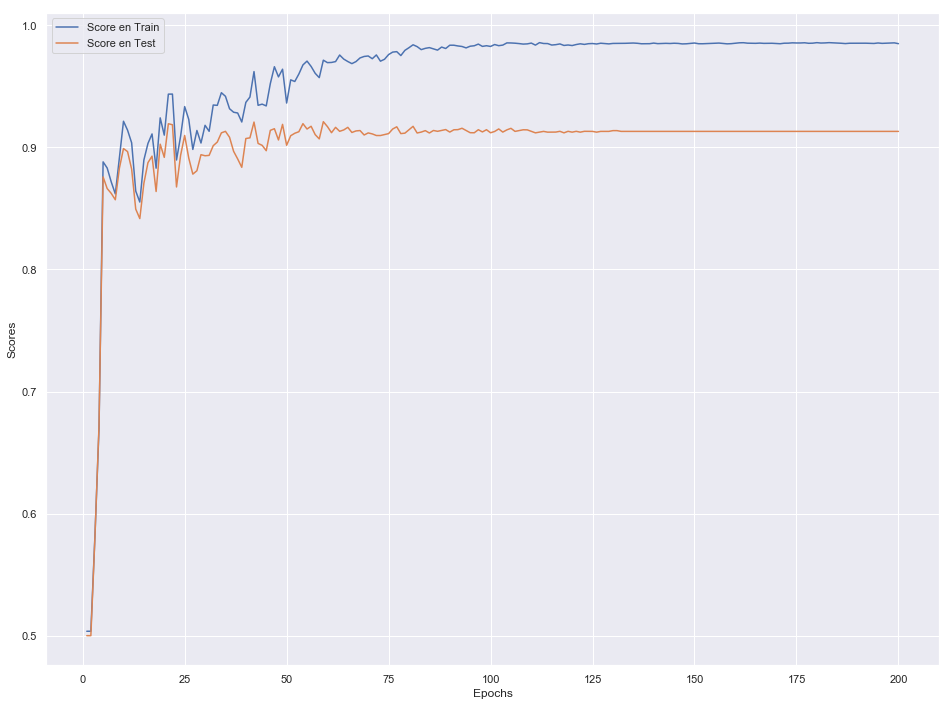

In [24]:
#Chargement des scores sur la base de train.
score_train_history_with_200_epochs = np.loadtxt("./historique/historique_score_train_with_200_epochs.txt")
score_test_history_with_200_epochs = np.loadtxt("./historique/istorique_score_test_with_200_epochs.txt")
fig = plt.figure(figsize=(16, 12))
xx = np.arange(1, len(score_train_history_with_200_epochs)+1)
plt.plot(xx, score_train_history_with_200_epochs, label="Score en Train")
plt.plot(xx, score_test_history_with_200_epochs, label="Score en Test")
plt.xlabel("Epochs")
plt.ylabel("Scores")
plt.legend()
plt.show()

#### Analyse du Graphe  
On remarque bien que le taux d'erreur en entrainement est toujours supérieur à celui sur la base de test. Par conséquent, notre modèle n'a à aucun moment donné été confronté à du surapprentissage (Taux d'erreur en test > Taux d'erreur en Train). 

Ci-dessous, on peut donc visualiser l'epoch durant laquelle nous avons obtenu le score maximale en Train et Test. 

##### Conclusion partielle  
Nous allons récupérer nos trois meilleurs modèles (ceux ayant le meilleur score en Test) afin d'évaluer la performance globale de notre modèle. Pour ce faire, nous allons faire l'évaluation sur toute notre base d'entrainement initiale, c'est à dire sur toutes les 111430 images. 

### Récupération des Scores en Train et en Test sous forme de tableau.  

In [29]:
tableau_train_test_score = pd.DataFrame(data = np.vstack((score_train_history_with_200_epochs,
                                                             score_test_history_with_200_epochs)).T,
                        index   = np.arange(1, len(score_train_history_with_200_epochs)+1),
                        columns = ['Score Train','Score Test'])

# Nous trions ensuite sur la colonne 'Score Test'
tableau_train_test_score.sort_values('Score Test', ascending=False, inplace=True)

#Récupération de nos trois meilleurs modèles.
tableau_train_test_score.head(3)

,Score Train,Score Test
59,0.971441,0.921050
42,0.962095,0.920744
54,0.967557,0.919430


### Conclusion   
On voit clairement que nos trois meilleurs modèles sont les suivants: 
- Model N°1, score en test = 0.921050 | Epoch = 59  
- Model N°2, score en test = 0.920744 | Epoch = 42  
- Model N°3, score en test = 0.919430 | Epoch = 54

# PARTIE IV: EVALUATION SUR TOUTE LA BASE

In [27]:
def give_mini_batch_score_for_all_Images(X, Y, mini_batch_size=256):
    
    m = X.shape[0]          # number of training examples
    mini_batches = []

    # Here we don't need to shuffle the data before splitting into mini-batches!
    
    # Partition (X, Y). Minus the end case.
    num_complete_minibatches = int(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [30]:
def compute_score_all_trainImages(model_to_restore, train_images_data, train_images_label, mbs=256, print_time=True):
    
    with tf.Session() as sess:
        t0 = time()
        
        # Restore the model
        saver = tf.train.Saver()
        saver.restore(sess, model_to_restore)
        
        # One hot encoding of the binary vector of labels
        train_images_label_encoded = np.eye(2)[train_images_label.astype(int).reshape(-1)]
        
        # Split into mini-batches
        minibatches = give_mini_batch_score_for_all_Images(train_images_data, train_images_label_encoded, mini_batch_size=mbs)
        sco_train = 0
        
        for i, minibatch in enumerate(minibatches):
            # Select a mini-batch
            (minibatch_X, minibatch_Y) = minibatch
            
            # Normalize Inputs
            minibatch_X_norm = np.divide(minibatch_X, 255., dtype=float)
            
            # Compute score on current mini-batch and add it to total
            trainDict = {x:minibatch_X_norm, y_true:minibatch_Y, ITM:False}
            sco_tmp = sess.run(score_chall, feed_dict=trainDict)
            sco_train += sco_tmp
            
            if print_time == True and i % 100 == 0:
                print("iteration %d - Execution time from start: %.2f (sec)"%(i, time()-t0))
        
        m = train_images_label_encoded.shape[0]
        sco_train = sco_train / (m/mbs)
        
        print("Execution Time : %.3f (sec)" % (time()-t0))
        print("  ==> Score = %.6f" % sco_train)
        
        return sco_train

# EVALUATION DE NOS TROIS MEILLEURS MODELS  
### Models N°1: score en test = 0.921050 | Epoch = 59 

In [31]:
model_to_restore = "./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_59"

score_allTrainImages_ep59 = compute_score_all_trainImages(model_to_restore, train_images_data, train_images_label,
                                                  mbs=256, print_time=True)

INFO:tensorflow:Restoring parameters from ./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_59
iteration 0 - Execution time from start: 1.17 (sec)
iteration 100 - Execution time from start: 60.96 (sec)
iteration 200 - Execution time from start: 122.32 (sec)
iteration 300 - Execution time from start: 182.87 (sec)
iteration 400 - Execution time from start: 245.89 (sec)
Execution Time : 266.569 (sec)
  ==> Score = 0.952540


### Models N°2:   score en test = 0.920744 | Epoch = 42   

In [32]:
model_to_restore = "./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_42"

score_allTrainImages_ep42 = compute_score_all_trainImages(model_to_restore, train_images_data, train_images_label,
                                                  mbs=256, print_time=True)

INFO:tensorflow:Restoring parameters from ./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_42
iteration 0 - Execution time from start: 1.18 (sec)
iteration 100 - Execution time from start: 60.73 (sec)
iteration 200 - Execution time from start: 124.28 (sec)
iteration 300 - Execution time from start: 186.14 (sec)
iteration 400 - Execution time from start: 247.16 (sec)
Execution Time : 267.143 (sec)
  ==> Score = 0.946552


### Models N°3:  score en test = 0.919430 | Epoch = 54

In [33]:
model_to_restore = "./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_54"

score_allTrainImages_ep54 = compute_score_all_trainImages(model_to_restore, train_images_data, train_images_label,
                                                  mbs=256, print_time=True)

INFO:tensorflow:Restoring parameters from ./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_54
iteration 0 - Execution time from start: 1.10 (sec)
iteration 100 - Execution time from start: 60.37 (sec)
iteration 200 - Execution time from start: 117.84 (sec)
iteration 300 - Execution time from start: 175.47 (sec)
iteration 400 - Execution time from start: 234.41 (sec)
Execution Time : 254.617 (sec)
  ==> Score = 0.950244


**NB** : Compte tenu des valeurs que nous avons obtenues, nous pouvons dire que notre modèle a une bonne capacité de généralisation. Mais le premier reste toujours le meilleur, qui a un bon pourcentage de prédiction par rapport aux deux derniers.

# PARTIE IV : LANCEMENT DES PREDICTIONS  DANS UN FICHIER TEXTE.
Pour faire cela, nous aurons besoin des fonctions ci-dessous qui nous serons d'une grande utilité.  

In [35]:
def prediction_for_minibatches(X, mini_batch_size=64):
    m = X.shape[0]
    mini_batches = []

    num_complete_minibatches = int(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batches.append(mini_batch_X)
    
    if m % mini_batch_size != 0:
        mini_batch_X = X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batches.append(mini_batch_X)
    
    return mini_batches

In [36]:
def launch_final_prediction(model_to_restore, images, mbs=256, print_time=True):
    
    with tf.Session() as sess:
        t0 = time()
        
        # Restoration du modèle
        saver = tf.train.Saver()
        saver.restore(sess, model_to_restore)
        
        # Normalization des inputs, comme précédemment(après la séparation de notre base train)
        images_norm = np.divide(images, 255., dtype=float)
        
        # Découpage en minibatches
        #print("I am here 1")
        predictions = np.array([])
        #print("I am here 2")

        minibatches = prediction_for_minibatches(images_norm, mini_batch_size=mbs)
        #print("I am here 3")
        # Calcul de la prédiction pour chaque minibatch.
        for i, minibatch_X in enumerate(minibatches):
            #print("I am here 4")
            minibatch_pred = sess.run(y_pred_vector, feed_dict={x:minibatch_X, ITM:False})
            #print("I am here 5")
            # Ajout du minibatch dans le tableau de prédictions
            predictions = np.append(predictions, minibatch_pred, axis=0)
        print("Temps execution : %.2f (sec)" % (time()-t0))
        print("Nombre de ligne du fichier \'prediction.txt':", predictions.shape[0])  
        #print(predictions)
        return  predictions

## A- Debut des predictions dans le fichier .txt avec le meilleur modèle

In [37]:
meilleur_model_epoch_59 = "./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_59"
pred_test = launch_final_prediction(meilleur_model_epoch_59,test_images_data , mbs=256)

#Sauvegarde dans le fichier .txt
np.savetxt("./predictions/prediction.txt", pred_test, fmt="%2d")

INFO:tensorflow:Restoring parameters from ./resultats_modeles/Model_KeepPD0.80_MBSize256_NbBlock4_ConvPerB2_NbFilter10_Learn_R0.0030_L2Rg-0.001.ckpt_epoch_59
Temps execution : 24.41 (sec)
Nombre de ligne du fichier 'prediction.txt': 10130
